In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
import nltk
from model import *
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
aita_raw_df = pd.read_csv('aita_minimal_preprocess.csv')
aita_raw_df

,Unnamed: 0,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,post,length
0,0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1,[AITA] I wrote an explanation in TIL and came ...,106
1,1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0,1,[AITA] Threw my parent's donuts awayMy parents...,180
2,2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0,I told a goth girl she looked like a clown.I w...,13
3,3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,everyone sucks,22,3.0,1,[AItA]: Argument I had with another redditor i...,21
4,4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,NaN,False,not the asshole,6,4.0,0,[AITA] I let my story get a little long and bo...,25
...,...,...,...,...,...,...,...,...,...,...,...,...
97623,97623,ex94w5,1.580577e+09,AITA for telling my sister she is being a spoi...,My sister(17F) and I(15M) are white kids born ...,1580585457.0,not the asshole,16,23.0,0,AITA for telling my sister she is being a spoi...,170
97624,97624,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the asshole,1373,304.0,0,AITA for telling my husband to f* off after he...,545
97625,97625,ex9dwo,1.580578e+09,AITA for attempting to keep my students out of...,Upfront apologies for formatting. I’m also try...,False,not the asshole,4,15.0,0,AITA for attempting to keep my students out of...,419
97626,97626,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the asshole,280,140.0,0,WIBTA if I left my brothers fate up to the sta...,283


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    aita_raw_df.post.values, 
    aita_raw_df.is_asshole.values,
    stratify = aita_raw_df.is_asshole.values,
    test_size = 0.2, 
    random_state = 448
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    stratify = y_train,
    test_size = 0.2, 
    random_state = 448
)
print(X_train[0])
print(y_train[0])

AITA for wanting to dump a girl after finding out she has an STD?So I (32m) started dating a new girl (26f) after a disgusting horrible divorce from my wife who I’ve been with for like 15 years.. 

So I was super patent and deliberate in choosing a girl to date, turning down lots of others over the last year or so of separation... Then I met this girl and she is like EVERYTHING I want in a woman, and I could really see myself having a long-term relationship with her. 

We took things slow and waited about a month to have sex, just fooling around and doing other stuff. Then when the time came she stopped me right before and told me she had been living with herpes since the age of 19.. She was very mature and responsible and understanding and said she’d give me time to think about it, but...TBH I’m fucking freaking out. I’m terrified that this could affect me and my life forever if I end up being with her.

I basically told her all of this, and broke up with her. I said that I couldn’t r

In [5]:
embed = KeyedVectors.load('glove300.kv')

In [6]:
unk = torch.FloatTensor(np.mean(embed.vectors, axis=0))

In [7]:
embed_tensor_dict = tensor_embeds(embed)

/home/maroofr/class/448/mde/nn/model.py:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return {k: torch.FloatTensor(embed[k]) for k in embed.index_to_key}


In [8]:
train_data = AITADataset(X_train, y_train, embed_tensor_dict, unk)
dev_data = AITADataset(X_val, y_val, embed_tensor_dict, unk)
test_data = AITADataset(X_test, y_test, embed_tensor_dict, unk)

In [9]:
train_loader = DataLoader(train_data, batch_size=64, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=64, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, collate_fn=basic_collate_fn, shuffle=False)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
overfit_df = aita_raw_df[aita_raw_df["length"] > 500][:1000]
overfit_data = AITADataset(overfit_df.post.values, overfit_df.is_asshole.values, embed_tensor_dict, unk)
overfit_loader = DataLoader(overfit_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=True)

In [14]:
counts = [0, 0]
for y in y_train:
    counts[y] += 1

pos_weight = torch.Tensor([counts[0] / counts[1]]).to(device)
pos_weight

tensor([2.6825], device='cuda:0')

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 32-- batch loss = 0.9358
Validation UAR: 0.5047
Validation accuracy: 0.2640
Validation loss: 1.0043
Epoch No. 2--Iteration No. 64-- batch loss = 0.9137
Validation UAR: 0.7846
Validation accuracy: 0.8860
Validation loss: 0.6398
Epoch No. 3--Iteration No. 96-- batch loss = 0.6876
Validation UAR: 0.9456
Validation accuracy: 0.9230
Validation loss: 0.2410
Epoch No. 4--Iteration No. 128-- batch loss = 0.4626
Validation UAR: 0.9786
Validation accuracy: 0.9720
Validation loss: 0.1418
Epoch No. 5--Iteration No. 160-- batch loss = 0.0081
Validation UAR: 0.9047
Validation accuracy: 0.9510
Validation loss: 0.3075
Epoch No. 6--Iteration No. 192-- batch loss = 0.0007
Validation UAR: 0.9974
Validation accuracy: 0.9980
Validation loss: 0.0117
Epoch No. 7--Iteration No. 224-- batch loss = 0.0130
Validation UAR: 0.9744
Validation accuracy: 0.9620
Validation loss: 0.1226
Training lasted 2.84 minutes
-------------

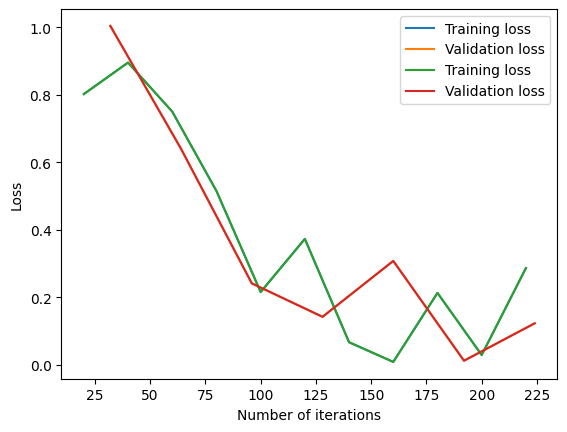

In [15]:
# test on validation to see if overfit is possible
torch.cuda.empty_cache() 
# net = textCNN(256, device, 0)
net = ensembleCNNBiGRU(256, 256, device, 0)
net.to(device)
optim = get_optimizer(net, lr=1e-2, weight_decay=0)
best_model, stats = train_model(net, overfit_loader, overfit_loader, optim,
                                num_epoch=7, collect_cycle=20, device=device, 
                                patience=None, pos_weight=pos_weight)
plot_loss(stats, False)
plot_loss(stats, True)

In [11]:
counts = [0, 0]
for y in y_train:
    counts[y] += 1
    
pos_weight = counts[0] / counts[1]
pos_weight

2.682501326103613

In [16]:
import itertools
from tqdm.notebook import tqdm
torch.cuda.empty_cache() 
torch.cuda.set_per_process_memory_fraction(0.95)

# Credit for this and a bunch of the training/validation code to EECS 487 staff
def search_param():
    """Experiemnt on different hyper parameters."""
    cnn_dense_hidden_dim, rnn_dense_hidden_dim, dropout_rate, lr, weight_decay = [256], [512], [0], [0.01], [0]
    total_comb = len(cnn_dense_hidden_dim) * len(rnn_dense_hidden_dim) * len(dropout_rate) * len(lr) * len(weight_decay)
    print("cnn hidden from: {}\nrnn hidden from: {}\nlr from: {}\nwd from: {}\ndropout from: {}".format(
        cnn_dense_hidden_dim, rnn_dense_hidden_dim, lr, weight_decay, dropout_rate
    ))
    best_model, best_stats = None, None
    best_accuracy, best_lr, best_wd, best_cnn_hd, best_rnn_hd, best_dr = 0, 0, 0, 0, 0, 0
    for cnn_hd, rnn_hd, dr, lr, wd in tqdm(
        itertools.product(cnn_dense_hidden_dim, rnn_dense_hidden_dim, dropout_rate, lr, weight_decay),
        total=total_comb
    ):
        net = ensembleCNNBiGRU(cnn_hd, rnn_hd, device, dr).to(device)
        optim = get_optimizer(net, lr=lr, weight_decay=wd)
        model, stats = train_model(net, train_loader, dev_loader, optim, num_epoch=100,
                                   collect_cycle=500, device=device, verbose=True, patience=10, pos_weight=pos_weight)
        # print accuracy
        print(f"{(cnn_hd, rnn_hd, dr, lr, wd)}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_lr, best_wd, best_cnn_hd, best_rnn_hd, best_dr = lr, wd, cnn_hd, rnn_hd, dr
    print("\n\nBest cnn hidden: {}, Best rnn hidden: {}, Best weight_decay: {}, Best lr: {}, Best dropout: {}".format(
        best_cnn_hd, best_rnn_hd, best_wd, best_lr, best_dr))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model
basic_model = search_param()

cnn hidden from: [256]
rnn hidden from: [512]
lr from: [0.01]
wd from: [0]
dropout from: [0]


  0%|          | 0/1 [00:00<?, ?it/s]

------------------------ Start Training ------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 522.00 MiB (GPU 0; 4.00 GiB total capacity; 1.85 GiB already allocated; 149.25 MiB free; 3.80 GiB allowed; 1.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
best_model = ensembleCNNBiGRU(256, 512, device, 0)
best_model.load_state_dict(torch.load('best_ensemble_nn.pt'))
best_model.eval()
best_model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
test_uar, test_accuracy, test_total_loss = get_validation_performance(best_model, loss_fn, test_loader, device) 
    
print(f"UAR on test: {test_uar}, Accuracy on test set: {test_accuracy}, Loss on test set {test_total_loss}")

UAR on test: 0.5966012385121984, Accuracy on test set: 0.5848099969271741, Loss on test set 0.6497099935229308
